<a href="https://colab.research.google.com/github/NyxLumen/Encephlo/blob/main/encephlo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Install the Kaggle API
!pip install kaggle

# Create a directory for Kaggle configuration and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set the permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip brain-tumor-mri-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0726.jpg  
  in

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
DATA_PATH = "/content/dataset/Training"

cuda


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Standardize size
    transforms.RandomRotation(10),       # Augmentation: handle slight head tilts
    transforms.ToTensor(),               # Convert pixels to 0-1 scale
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
])

# Validation transform is 'clean' for honest accuracy check
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_set_full = datasets.ImageFolder(root=DATA_PATH, transform=train_transform)
val_set_full = datasets.ImageFolder(root=DATA_PATH, transform=val_transform)

In [8]:
indices = np.arange(len(train_set_full))
np.random.seed(42)
np.random.shuffle(indices)
split = int(0.8 * len(indices))

In [9]:
train_data = Subset(train_set_full, indices[:split])
val_data = Subset(val_set_full, indices[split:])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset Split: {len(train_data)} Train, {len(val_data)} Val")
print(f"Classes: {train_set_full.classes}")

Dataset Split: 4569 Train, 1143 Val
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
def build_model():
    model = models.efficientnet_v2_s(weights='DEFAULT')

    # Replace the final layer to match your 4 classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Dropout(p=0.3), # Prevents the model from "memorizing" specific scans
        nn.Linear(num_features, 4) # Changed from 2 to 4 classes
    )
    return model.to(device)

model = build_model()

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Prevents overconfidence
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler('cuda')

In [12]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def run_phase(loader, model, criterion, optimizer=None, scaler=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(is_train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            if is_train:
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total

print("Starting Training...")
for epoch in range(10):
    t_loss, t_acc = run_phase(train_loader, model, criterion, optimizer, scaler)
    v_loss, v_acc = run_phase(val_loader, model, criterion)

    scheduler.step(v_loss)

    history['train_loss'].append(t_loss); history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc); history['val_acc'].append(v_acc)

    print(f"Epoch {epoch+1}: Train Acc {t_acc:.2f}% | Val Acc {v_acc:.2f}% | Val Loss {v_loss:.4f}")

Starting Training...
Epoch 1: Train Acc 88.75% | Val Acc 93.70% | Val Loss 0.4817
Epoch 2: Train Acc 94.73% | Val Acc 96.68% | Val Loss 0.4256
Epoch 3: Train Acc 96.52% | Val Acc 96.15% | Val Loss 0.4342
Epoch 4: Train Acc 96.28% | Val Acc 96.85% | Val Loss 0.4160
Epoch 5: Train Acc 97.66% | Val Acc 97.81% | Val Loss 0.3985
Epoch 6: Train Acc 98.16% | Val Acc 97.81% | Val Loss 0.4049
Epoch 7: Train Acc 98.34% | Val Acc 98.08% | Val Loss 0.3928
Epoch 8: Train Acc 98.42% | Val Acc 97.29% | Val Loss 0.4137
Epoch 9: Train Acc 98.40% | Val Acc 95.01% | Val Loss 0.4664
Epoch 10: Train Acc 98.42% | Val Acc 98.08% | Val Loss 0.3955


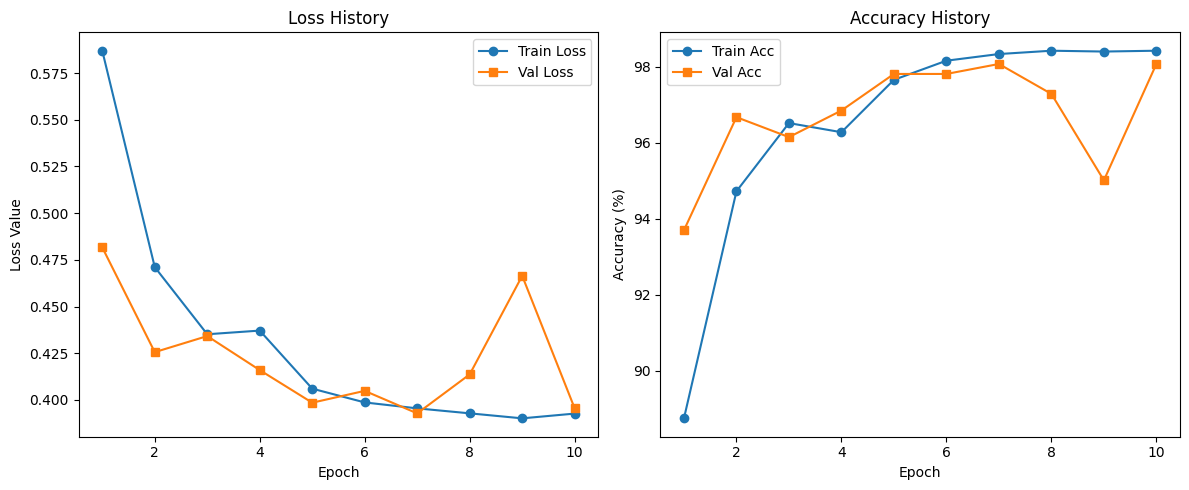

In [38]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

# 1. Loss History Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o') # 'epochs' on X-axis
plt.plot(epochs, history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss History')
plt.xlabel('Epoch') # Clearly label the X-axis
plt.ylabel('Loss Value')
plt.legend()

# 2. Accuracy History Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o') # 'epochs' on X-axis
plt.plot(epochs, history['val_acc'], label='Val Acc', marker='s')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout() # Prevents overlapping of subplots
plt.show()


In [45]:
torch.save(model.state_dict(), 'trial.h5')

In [28]:
import random
import matplotlib.pyplot as plt
from PIL import Image # For loading images directly
import torch.nn.functional as F # For softmax

# Mapping of category indices to labels
# Assuming test_set_full.classes gives the correct order
category_labels = test_set.classes

def denormalize_image(tensor_image):
    """Denormalizes a tensor image for display."""
    # Standard normalization values for ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    # Reverse the normalization: img = img * std + mean
    denormalized_img = tensor_image * std + mean
    # Clip values to [0, 1] to ensure valid image data
    denormalized_img = torch.clamp(denormalized_img, 0, 1)
    return denormalized_img.permute(1, 2, 0).cpu().numpy() # Convert from (C, H, W) to (H, W, C) for matplotlib

Predicting on 8 random images from the test set...


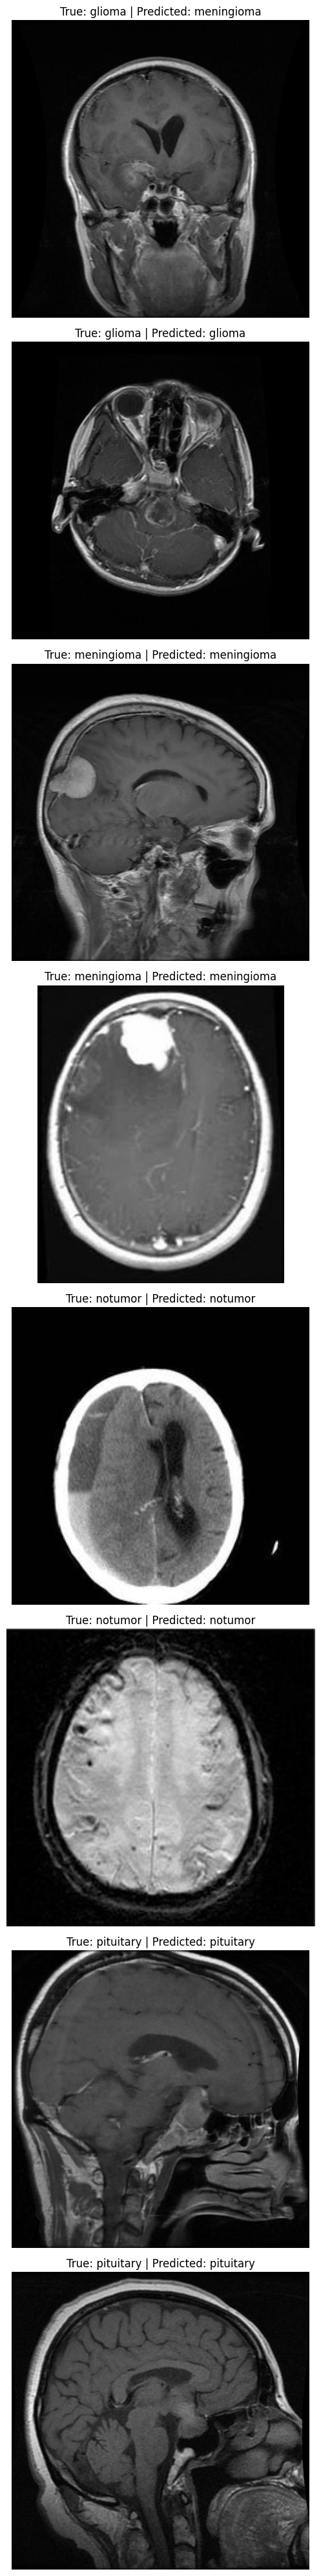


Detailed Predictions:
Image: Te-gl_0044.jpg - True Label: glioma - Predicted: meningioma
Image: Te-gl_0091.jpg - True Label: glioma - Predicted: glioma
Image: Te-me_0240.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-meTr_0008.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-noTr_0000.jpg - True Label: notumor - Predicted: notumor
Image: Te-noTr_0008.jpg - True Label: notumor - Predicted: notumor
Image: Te-pi_0256.jpg - True Label: pituitary - Predicted: pituitary
Image: Te-pi_0264.jpg - True Label: pituitary - Predicted: pituitary


In [36]:
def predict_on_random_test_images(model, test_set, num_samples_per_class=1):
    model.eval() # Set model to evaluation mode
    predictions = []

    # Get all image paths and their labels from the test set
    all_test_samples = test_set.samples

    # Group samples by class to pick an equal number from each
    samples_by_class = {class_idx: [] for class_idx in range(len(test_set.classes))}
    for img_path, class_idx in all_test_samples:
        samples_by_class[class_idx].append(img_path)

    selected_images = []
    for class_idx in samples_by_class:
        # Ensure we don't try to sample more images than available
        num_to_sample = min(num_samples_per_class, len(samples_by_class[class_idx]))
        selected_images.extend(random.sample(samples_by_class[class_idx], num_to_sample))

    print(f"Predicting on {len(selected_images)} random images from the test set...")

    plt.figure(figsize=(15, 5 * len(selected_images)))
    for i, img_path in enumerate(selected_images):
        # Load the original image for display
        pil_image = Image.open(img_path).convert('RGB')

        # Apply the test transformations for prediction
        input_tensor = test_transform(pil_image)
        input_batch = input_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        with torch.no_grad(): # Disable gradient calculations for inference
            outputs = model(input_batch)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_idx = torch.max(probabilities, 1)

        predicted_label = category_labels[predicted_idx.item()]

        # Find the true label from the test_set.samples
        true_label = "Unknown" # Default if not found, though it should be
        for path, label_idx in all_test_samples:
            if path == img_path:
                true_label = category_labels[label_idx]
                break

        predictions.append((img_path, predicted_label, true_label))

        # Display the image with prediction
        plt.subplot(len(selected_images), 1, i + 1)
        plt.imshow(pil_image) # Display original PIL image
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return predictions

# Run the prediction function
# You can change num_samples_per_class to visualize more images per class
visualization_predictions = predict_on_random_test_images(model, test_set, num_samples_per_class=2)

# Print the predictions
print("\nDetailed Predictions:")
for img_path, pred_label, true_label in visualization_predictions:
    print(f"Image: {os.path.basename(img_path)} - True Label: {true_label} - Predicted: {pred_label}")

Predicting on 8 random images from the test set...


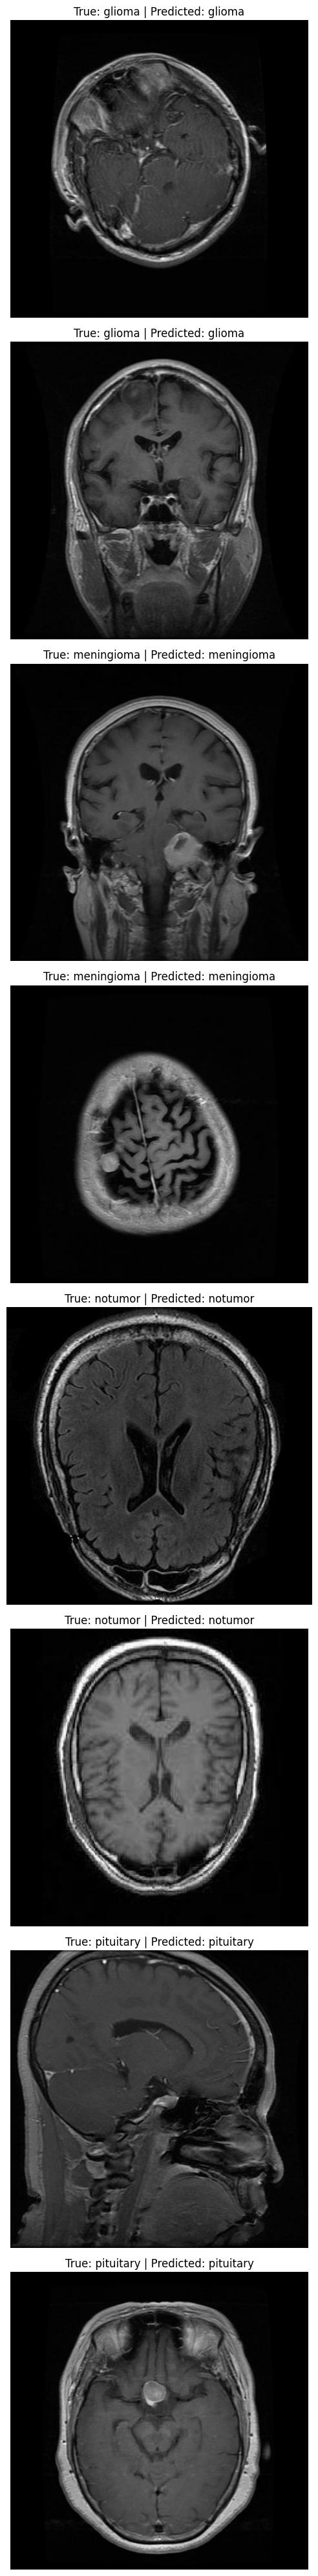


Detailed Predictions:
Image: Te-glTr_0006.jpg - True Label: glioma - Predicted: glioma
Image: Te-gl_0125.jpg - True Label: glioma - Predicted: glioma
Image: Te-me_0188.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-me_0254.jpg - True Label: meningioma - Predicted: meningioma
Image: Te-no_0333.jpg - True Label: notumor - Predicted: notumor
Image: Te-no_0320.jpg - True Label: notumor - Predicted: notumor
Image: Te-pi_0250.jpg - True Label: pituitary - Predicted: pituitary
Image: Te-pi_0186.jpg - True Label: pituitary - Predicted: pituitary


In [26]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# Define category_labels here, after test_set has been defined
category_labels = test_set.classes

# Run the prediction and visualization function again
# You can change num_samples_per_class to visualize more images per class
visualization_predictions = predict_on_random_test_images(model, test_set, num_samples_per_class=2)

# Print the detailed predictions
print("\nDetailed Predictions:")
for img_path, pred_label, true_label in visualization_predictions:
    print(f"Image: {os.path.basename(img_path)} - True Label: {true_label} - Predicted: {pred_label}")

In [21]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

TEST_DATA_PATH = "/content/dataset/Testing"
test_set = datasets.ImageFolder(root=TEST_DATA_PATH, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of test images: {len(test_set)}")

Number of test images: 1311


In [37]:
model = build_model() # Re-initialize the model architecture
model.load_state_dict(torch.load('brain_tumor_best.pth')) # Load the saved weights
model.eval() # Set model to evaluation mode

# Reuse the run_phase function for testing
# For testing, we don't need an optimizer or scaler
test_loss, test_acc = run_phase(test_loader, model, criterion, optimizer=None, scaler=None)

print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 99.39%
Test Loss: 0.3628
